### qdrant collection EDA

In [1]:
import sys
import numpy as np
from collections import Counter
from qdrant_client import QdrantClient
from sciencesage.config import QDRANT_URL, QDRANT_COLLECTION, EMBEDDING_DIM, ARIZE_SPACE_ID, ARIZE_API_KEY
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import time
from arize.api import Client

2025-10-04 20:05:54.952 | INFO     | sciencesage.config:<module>:159 - Configuration loaded.


In [2]:
print("Connecting to Qdrant...")
qdrant_client  = QdrantClient(url=QDRANT_URL)

Connecting to Qdrant...


In [3]:
print("Connecting to Arize...")
arize_client = Client(space_id=ARIZE_SPACE_ID, api_key=ARIZE_API_KEY)

Connecting to Arize...


In [4]:
def check_collection_size():
    """Get number of points in the collection"""
    info = qdrant_client.get_collection(QDRANT_COLLECTION)
    print(f"Total vectors in collection: {info.points_count}")
    print(info.config)

In [5]:
check_collection_size()

Total vectors in collection: 2713
params=CollectionParams(vectors=VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None) hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None) optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=None) wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0) quantization_config=None strict_mode_config=StrictModeConfigOutput(enabled=False, max_query_limit=None, max_timeout=None, unindexed_filtering_retrieve=None, unindexed_filtering_update=No

In [6]:
def check_vector_dimensions():
    """Confirm all vectors have correct dimensionality"""
    info = qdrant_client.get_collection(QDRANT_COLLECTION)
    print(f"Expected vector size: {info.config.params.vectors.size}")


In [7]:
check_vector_dimensions()

Expected vector size: 384


In [8]:
def inspect_payload_fields(sample_size=10):
    """Sample points to inspect payload keys and values"""
    dummy_vector = [0.1] * EMBEDDING_DIM
    results = qdrant_client.search(
        collection_name=QDRANT_COLLECTION,
        query_vector=dummy_vector,
        limit=sample_size,
        with_payload=True
    )
    for i, point in enumerate(results):
        print(f"Sample {i} - ID: {point.id}, Payload keys: {list(point.payload.keys())}, Payload values: {point.payload}")


In [9]:
inspect_payload_fields(sample_size=10)

Sample 0 - ID: c9eb057a-5a09-5ba0-ac63-e6aa28e67995, Payload keys: ['chunk_id', 'text', 'title', 'source_url', 'categories', 'topic', 'images', 'summary', 'chunk_index', 'char_start', 'char_end', 'created_at', 'embedding'], Payload values: {'chunk_id': None, 'text': 'Fully loaded, the LRV has a ground clearance of 14 inches (36 cm)..', 'title': 'Lunar Roving Vehicle', 'source_url': 'https://en.wikipedia.org/wiki/Lunar_Roving_Vehicle', 'categories': ['Category:1971 on the Moon', 'Category:1972 on the Moon', 'Category:Apollo 15', 'Category:Apollo 16', 'Category:Apollo 17', 'Category:Apollo program hardware', 'Category:Electric cars', 'Category:Exploration of the Moon', 'Category:Lunar rovers', 'Category:Missions to the Moon', 'Category:NASA vehicles', 'Category:Off-road vehicles'], 'topic': 'moon', 'images': ['https://upload.wikimedia.org/wikipedia/commons/e/e5/AS17-137-20979.jpg', 'https://upload.wikimedia.org/wikipedia/commons/e/ed/Apollo15LunarRover.jpg', 'https://upload.wikimedia.org

/tmp/ipykernel_185938/391899013.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = qdrant_client.search(


In [10]:
def estimate_payload_distribution(field, sample_size=1000):
    """Estimate distribution of values in a payload field by sampling points."""
    points, _ = qdrant_client.scroll(collection_name=QDRANT_COLLECTION, limit=sample_size, with_payload=True)
    values = []
    for p in points:
        if hasattr(p, "payload"):
            value = p.payload.get(field, None)
            if isinstance(value, (list, dict)):
                value = str(value)
            values.append(value)
    counts = Counter(values)
    print(f"\nDistribution for field '{field}' (top 10):")
    for val, count in counts.most_common(10):
        print(f"  {val}: {count}")
    print(f"Total unique values: {len(counts)}")

In [11]:
estimate_payload_distribution("topic")


Distribution for field 'topic' (top 10):
  moon: 412
  mars: 346
  other: 167
  space exploration: 37
  planets: 28
  animals in space: 10
Total unique values: 6


In [12]:
estimate_payload_distribution("source_url")


Distribution for field 'source_url' (top 10):
  https://en.wikipedia.org/wiki/Moon_landing: 31
  https://en.wikipedia.org/wiki/Exploration_of_Mars: 29
  https://en.wikipedia.org/wiki/Timeline_of_Opportunity: 28
  https://en.wikipedia.org/wiki/Apollo_program: 27
  https://en.wikipedia.org/wiki/Exploration_of_Io: 24
  https://en.wikipedia.org/wiki/Spacecraft_propulsion: 23
  https://en.wikipedia.org/wiki/Artemis_program: 23
  https://en.wikipedia.org/wiki/Colonization_of_Mars: 20
  https://en.wikipedia.org/wiki/History_of_Solar_System_formation_and_evolution_hypotheses: 20
  https://en.wikipedia.org/wiki/Space_exploration: 20
Total unique values: 136


In [13]:
def fetch_embeddings(sample_size=500):
    """
    Fetch the 'embedding' vectors from Qdrant payloads.
    Returns: np.ndarray of shape (n_points, embedding_dim)
    """
    points, _ = qdrant_client.scroll(collection_name=QDRANT_COLLECTION, limit=sample_size)
    embeddings = []
    for p in points:
        emb = p.payload.get("embedding", None)
        if emb is not None and isinstance(emb, list) and len(emb) == EMBEDDING_DIM:
            embeddings.append(emb)
    return np.array(embeddings)

In [14]:
def visualize_pca_umap(embeddings):
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.scatter(pca_result[:,0], pca_result[:,1], s=10)
    plt.title("PCA (2D)")

    # UMAP
    reducer = umap.UMAP(n_components=2)
    umap_result = reducer.fit_transform(embeddings)
    plt.subplot(1,2,2)
    plt.scatter(umap_result[:,0], umap_result[:,1], s=10)
    plt.title("UMAP (2D)")
    plt.tight_layout()
    plt.show()

Sample embedding from first point: [ 0.04627267 -0.06653053  0.04313018  0.07444657  0.007512    0.05987068
 -0.08770306 -0.02219147 -0.02859418  0.01232818]...


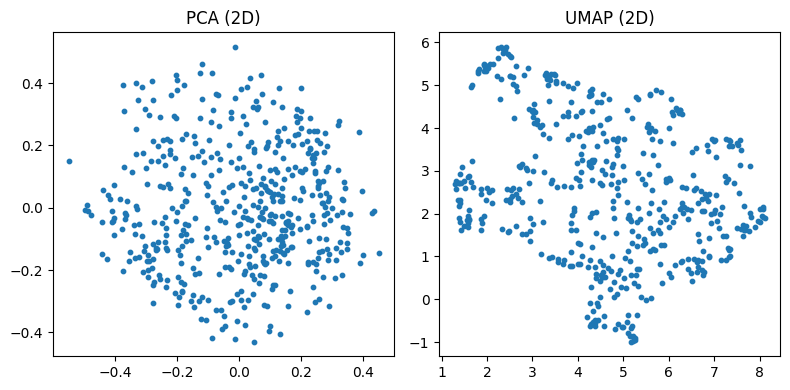

In [15]:
embeddings = fetch_embeddings(sample_size=500)
if embeddings.size > 0:
    print(f"Sample embedding from first point: {embeddings[0][:10]}...")  # Print first 10 dimensions of the first embedding
    visualize_pca_umap(embeddings)
else:
    print("No valid embeddings found for visualization.")



In [16]:
points, _ = qdrant_client.scroll(collection_name=QDRANT_COLLECTION, limit=5, with_payload=True)
for p in points:
    print("ID:", getattr(p, "id", None))
    print("Embedding:", p.payload.get("embedding", []))
    print("Payload:", getattr(p, "payload", None))
    print("---")

ID: 001f1d98-8467-581c-9b50-aa561949bbf6
Embedding: [0.04627267271280289, -0.06653052568435669, 0.04313017800450325, 0.07444656640291214, 0.00751200458034873, 0.059870682656764984, -0.08770306408405304, -0.022191466763615608, -0.028594182804226875, 0.01232817955315113, 0.018341153860092163, 0.15364985167980194, -0.01995795965194702, -0.055033084005117416, -0.06003045290708542, 0.02571091055870056, 9.61035220825579e-06, -0.02684231847524643, 0.005957060493528843, -0.030842311680316925, -0.019544405862689015, 0.02889733575284481, -0.060251832008361816, 0.06758765876293182, 0.04234316200017929, 0.05489332973957062, -0.02454390563070774, -0.03393134847283363, -0.013882671482861042, 0.04721701517701149, 0.043203916400671005, -0.03640080615878105, 0.01857585273683071, 0.0037880849558860064, 0.08813150227069855, 0.11129546910524368, -0.015331877395510674, -0.07611797749996185, -0.012601325288414955, 0.002252869075164199, 0.028651166707277295, -0.09451844543218613, 0.01439535804092884, 0.00135

In [17]:
def test_nearest_neighbor_query(query_vector):
    """Run a sample nearest neighbor query and print result distances"""
    results = qdrant_client.query_points(
        collection_name=QDRANT_COLLECTION,
        query=query_vector,
        limit=5,
        with_payload=True
    )
    for point in results.points:
        print(f"ID: {point.id}, Distance: {point.score}, Payload: {point.payload}")

In [18]:
model = SentenceTransformer("all-MiniLM-L6-v2")
query_vector = model.encode("What animal went to space first?").tolist()
test_nearest_neighbor_query(query_vector)

ID: 94084b51-db55-5442-a6de-0ad20052f45c, Distance: 0.6440823, Payload: {'chunk_id': None, 'text': 'Animals in space originally served to test the survivability of spaceflight, before human spaceflights were attempted. Later, many species were flown to investigate various biological processes and the effects microgravity and space flight might have on them. Bioastronautics is an area of bioengineering research that spans the study and support of life in space. To date, seven national space programs have flown non-human animals into space: the United States, Soviet Union, France, Argentina, China, Japan and Iran.\nA wide variety of non-human animals have been launched into space, including monkeys and apes, dogs, cats, tortoises, mice, rats, rabbits, fish, frogs, spiders, insects, and quail eggs (which hatched on Mir in 1990). The US launched the first Earthlings into space, with fruit flies surviving a 1947 flight, followed by primates in 1949. The Soviet space program launched multipl

### TODO: Set up Arize

In [ ]:
# ### TODO: Set up Arize

# The following code is commented out for now.
# Uncomment and configure when ready to log to Arize.

# # Before your query
# start_time = time.time()
#
# # Run your query
# model = SentenceTransformer("all-MiniLM-L6-v2")
# query_vector = model.encode("What animal went to space first?").tolist()
# test_nearest_neighbor_query(query_vector)
#
# # After your query
# elapsed_time = int((time.time() - start_time) * 1000)  # milliseconds
#
# # Now you can use elapsed_time in arize_client.log
# arize_client.log(
#     model_id="qdrant-retrieval",
#     model_version="v1",
#     prediction_id="unique_id",
#     prediction_label="retrieved_text",
#     features={"query": "What animal went to space first?"},
#     embeddings={"query_embedding": query_vector}, 
#     response_time_ms=elapsed_time,
#     tags={"source": "qdrant", "topic": "space"},
# )

ID: 94084b51-db55-5442-a6de-0ad20052f45c, Distance: 0.6440823, Payload: {'chunk_id': None, 'text': 'Animals in space originally served to test the survivability of spaceflight, before human spaceflights were attempted. Later, many species were flown to investigate various biological processes and the effects microgravity and space flight might have on them. Bioastronautics is an area of bioengineering research that spans the study and support of life in space. To date, seven national space programs have flown non-human animals into space: the United States, Soviet Union, France, Argentina, China, Japan and Iran.\nA wide variety of non-human animals have been launched into space, including monkeys and apes, dogs, cats, tortoises, mice, rats, rabbits, fish, frogs, spiders, insects, and quail eggs (which hatched on Mir in 1990). The US launched the first Earthlings into space, with fruit flies surviving a 1947 flight, followed by primates in 1949. The Soviet space program launched multipl

TypeError: Client.log() got an unexpected keyword argument 'embeddings'